In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import accuracy_score

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import learning_curve

In [2]:
# loading the data
df = pd.read_csv('./Data/Final_18_features_extracted_V2.csv')

In [3]:
X = df.drop(columns=["Region","File Name"],axis=1)
y = df['Region']

In [4]:
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.3,random_state=17,shuffle=True
)

- Lets initiazlize our CV with skf
- Initialize ExtratreeClassifier with default values
- In default values, the hyperparameters values are:
  - n_estimators: 100
  - criterion: gini
  - max_depth: None
  - min_samples_split: 2
  - min_samples_leaf: 2
  - max_features: auto (sqrt)
  - max_leaf_nodes: None
  - bootstrap: False

In [5]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=17)
extraTree = ExtraTreesClassifier(random_state=17,n_jobs=-1)

- Lets check our CV scores with default parameters

In [6]:
results = cross_val_score(extraTree,X_train,y_train,cv=skf)
results.mean()*100

79.79808488265432

- Lets now check train and test score with default parameters

In [7]:
extraTree.fit(X_train,y_train)

ExtraTreesClassifier(n_jobs=-1, random_state=17)

In [8]:
# accuracy on the train set:
pred = extraTree.predict(X_train)
accuracy_score(y_train,pred)

1.0

In [9]:
# accuracy on the test set:
pred = extraTree.predict(X_test)
accuracy_score(y_test,pred)

0.8027961736571008

---

- Alright so rn, I'm having the same problem... but accuracy on the test set increased just a bit... meaning **variance deacreased just a bit relative to previous model result**

- Lets use the parameters values I have guessed using validation curve in this model! I'm just gonna check the result, if not satisfied I'm gonna rework the validation curves for this model

In [10]:
forest_params = {
    'n_estimators':[10,15,20,25],
    'max_features': [4],
    'min_samples_leaf': [16,18,20],
    'max_depth': [7,10,13],
    'min_samples_split':[20,25,30]
}
extraTree = ExtraTreesClassifier(n_estimators=50,random_state=17,n_jobs=-1)
gcv = GridSearchCV(extraTree,forest_params,n_jobs=-1,cv=skf,verbose=1)

In [11]:
gcv.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=ExtraTreesClassifier(n_estimators=50, n_jobs=-1,
                                            random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [7, 10, 13], 'max_features': [4],
                         'min_samples_leaf': [16, 18, 20],
                         'min_samples_split': [20, 25, 30],
                         'n_estimators': [10, 15, 20, 25]},
             verbose=1)

In [12]:
gcv.best_estimator_

ExtraTreesClassifier(max_depth=13, max_features=4, min_samples_leaf=16,
                     min_samples_split=20, n_estimators=25, n_jobs=-1,
                     random_state=17)

In [13]:
# The CV scores
gcv.best_score_

0.6546300646575832

In [14]:
# accuracy on the train set
accuracy_score(gcv.best_estimator_.predict(X_train),y_train)

0.7172370288598013

In [15]:
# accuracy on the test set
accuracy_score(gcv.best_estimator_.predict(X_test),y_test)

0.6567328918322296

- Lets plot the learning curve

In [16]:
alphas = np.logspace(-2, 0, 20)
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [17]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train,val_train,val_test = learning_curve(
        gcv.best_estimator_,X_train,y_train,train_sizes=train_sizes,cv=skf,shuffle=True
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("Aaccuracy")
    plt.legend()
    plt.grid(True);

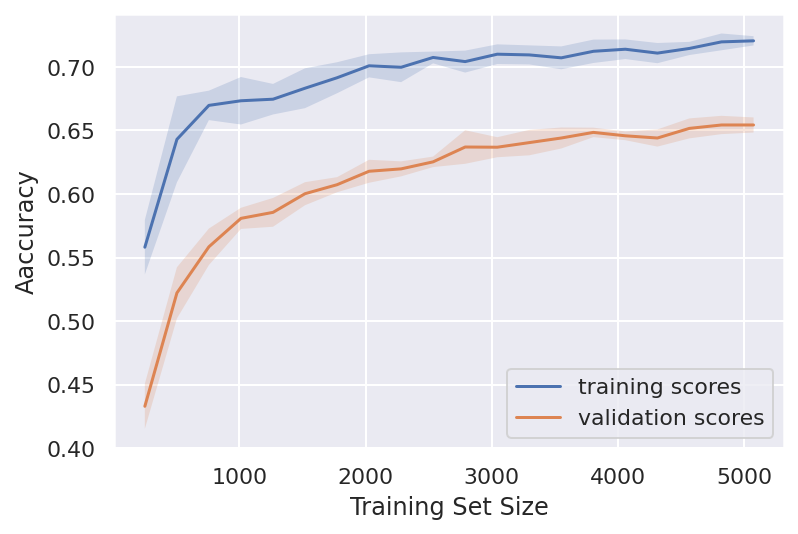

In [18]:
plot_learning_curve()

### Notes:
- The gap between training curve and validation curve decreased here a lot! 
- But, our bias of the model increased!